# K-Visitation analysis and distribution of $q_K$

**Description:**
This notebook reproduces Figure 2 and 3 in the manuscript.
1. **Figure 2a:** KDE distribution of alignment coefficients across cities.
2. **Figure 2b:** Comparison of $q_K$ between empirical data, no work scenario and null scenario.
3. **Figure 2c-d:** Comparison of experience segregation and POI diversity between $K_{freq}$ and $K_{dist}$ across the three scenarios.
4. **Figure 3:** Spatial mapping of $q_K$ in Helsinki, Tampere, Turku and Oulu regions.

**Data Source:** 
- `data/qk_grid.csv`: Aggregated grid-level metrics (Provided in repo).
- `data/poi_seg_diff.csv`: Aggregated grid-level POI diversity and segregation differences (Provided in repo).
- `data/finn_1km_grid.parquet`: Grid spatial data (Provided in repo).

In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import geopandas as gpd
import contextily as ctx
from pypalettes import load_cmap
from scipy import stats
from scipy.stats import gaussian_kde
from shapely.affinity import scale
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.colorbar import ColorbarBase

# Setup project root path
project_root = Path.cwd()
if 'notebooks' in str(project_root):
    project_root = project_root.parent

# Add src to path
src_path = str(project_root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Set data path
data_dir = project_root / 'data'

## Demo: Calculate K-visitation and local alignment $q_K$  for users
Below we include the code to calculate K-visitations for each user and their alignment coefficient $q_K$. 
For privacy issues, this is only for demonstration purposes with anonymised sample data.

In [2]:
from k_visitation import calculate_both_k_places, calculate_qk_alignment

# Load data
# The data containing user visitations, for testing purposes we use a sample anonymised data
data_path = data_dir / 'sample_anonymised_data.csv'

if data_path.exists():
    print(f"Loading data from {data_path}...")
    stay_locations = pd.read_csv(data_path)
    
else:
    print(f"Data file not found at {data_path}. Please check the path.")

Loading data from /Users/silver/Desktop/k-visitation-finland/data/sample_anonymised_data.csv...


In [3]:
amenity_list = [
    'CIVIC_RELIGION', 'CULTURE', 'DINING', 'EDUCATION', 'FITNESS', 
    'GROCERIES', 'HEALTHCARE', 'RETAIL', 'SERVICE', 'TRANSPORT'
]

smallest_values = np.ones(len(amenity_list), dtype=int)

# Calculate K-freq and K-dist for all users
places_k = calculate_both_k_places(stay_locations, amenity_list, smallest_values)



# Calculate qK alignment
user_qk = calculate_qk_alignment(
    places_df=places_k,
    user_col='user_id', 
    k_freq_col='k_freq',
    k_dist_col='k_dist'
)

print(user_qk.head())

k_type                               user_id  f0d0  f0d1  f1d0  f1d1        qk
0       084cd8d4-91be-4239-a740-4d703da8277a    13     1     1     2  0.500000
1       1b77f881-e3a5-4937-aa4b-bda8419cbb69     0     0     0     7  1.000000
2       29a55739-f004-2791-5ec4-d0792d22f7b5    11     0     0     1  1.000000
3       2ae0928e-22e9-40ca-ad99-d306f12c433c     6     3     1     5  0.555556
4       31c74126-dbdc-4c0b-b896-d5467cb49c65     1     3     2     4  0.444444


In [4]:
# This section aggregate user-level data to 1km grid level. For privacy concerns, the next cell is only shown to illustrate the aggregation process. 


# qk_grid = user_qk.groupby('home_grd_id').agg({
#     'user_id':'size',
#     'qk':'mean',
#     }
# ).reset_index()

## Aggregated grid-level data
Figures 2 and 3 can be reproduced from the main manuscript using pre-aggregated grid-level data for privacy compliance.

The loaded data contains following attributes:
- `grd_id`: 1km Finland official grid cell ID, each user is aggregated based on their the grid id their home location belonged to.
- `n_users`: Number of users we obtained in the grid cell.
- `popu`: Population in the grid cell, obtained from census data.
- `mean_qk`: Mean alignment coefficient of users in the grid cell.
- `mean_qk_nw`: Mean alignment coefficient of users in the grid cell excluding work-related trips.
- `mean_qk_null`: Mean alignment coefficient of users in the grid cell from null model (d-EPR model, see Methods).

In [5]:
qk_grid = pd.read_csv(data_dir / 'qk_grid.csv')
qk_grid.head()

,grd_id,n_users,popu,city,region,mean_qk,mean_qk_nw,log_poi,mean_qk_null
0,1kmN6638E0273,11,337.0,Hanko,Ekenäs,0.864448,0.898214,5.196114,0.380250
1,1kmN6638E0274,7,237.0,Hanko,Ekenäs,0.729592,0.892857,3.890621,0.358805
2,1kmN6639E0272,10,991.0,Hanko,Ekenäs,0.796791,0.956458,0.789691,0.416190
3,1kmN6639E0273,10,1269.0,Hanko,Ekenäs,0.507222,0.774561,1.945848,0.536806
4,1kmN6639E0274,12,1039.0,Hanko,Ekenäs,0.725032,0.710690,2.069127,0.450953


##  Fig 2a. KDE distribution of alignment coefficients across cities

Text(0.5, 33.20312500000037, '$q_K$')

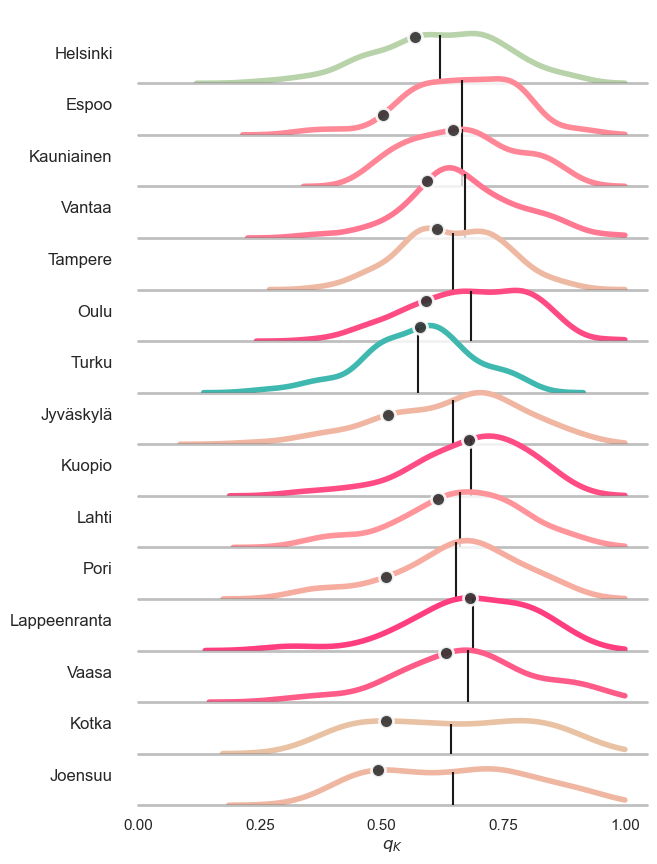

In [6]:
##### Visualisation: Figure 2a. KDE plots of qK distributions across cities



# Ten largest cities in Finland by population
cities = ['Helsinki', 
          'Espoo',
          'Kauniainen',
          'Vantaa',
          # Above is the helsinki region
          'Tampere', 
          'Oulu', 
          'Turku',
          'Jyväskylä', 
          'Kuopio', 
          'Lahti', 
          'Pori', 
          'Lappeenranta',
            'Vaasa',
            'Kotka',
            'Joensuu',
          ]

# Filter data
grid_filtered = qk_grid[qk_grid['n_users'] > 5] 
grid_cities = grid_filtered[grid_filtered['city'].isin(cities)].copy()

# Calculate mean qk for each city and assign to each row
city_means = grid_cities.groupby('city')['mean_qk'].mean()
grid_cities['mean_qk_city'] = grid_cities['city'].map(city_means)
# Calculate top 3 most populated grids for each city
top_by_city = {}
for city in cities:
    city_data = grid_cities[grid_cities['city'] == city]
    if len(city_data) > 0:
        top = city_data.nlargest(2, 'popu')
        # Calculate mean qk for top 2 grids
        top_mean = top['mean_qk'].mean()
        top_by_city[city] = top_mean


sns.set_theme(style='white')

base = load_cmap('miami2')
anchor_colors = base.colors
cmap = LinearSegmentedColormap.from_list(
    'miami2_continuous',
    anchor_colors,
    N=256
)


city_means = grid_cities.groupby('city')['mean_qk'].mean()
norm = mpl.colors.Normalize(city_means.min(), city_means.max())
color_mapping = {city: cmap(norm(m)) for city, m in city_means.items()}
pal = [color_mapping[city] for city in cities]


g = sns.FacetGrid(grid_cities, row='city', aspect=10, height=0.6, palette=pal, row_order=cities)

g.figure.set_dpi(100)

# Add the densities kdeplots for each city with colored fills
g.map(sns.kdeplot, 'mean_qk',
      bw_adjust=0.9, clip=(0, 1),
      color='w',
      fill=True, alpha=0.8, linewidth=0)

# Add colored outline for each kdeplot
for idx, (ax, city) in enumerate(zip(g.axes.flat, cities)):
      if idx < len(cities):
            city_data = grid_cities[grid_cities['city'] == city]['mean_qk'].dropna()
            if len(city_data) > 0:
                  sns.kdeplot(data=city_data, ax=ax, bw_adjust=0.9, clip=(0, 1), 
                            color=color_mapping[city], lw=4, fill=False)

# Add horizontal line for each plot
g.map(plt.axhline, y=0, color='grey', alpha=0.5, lw=2, clip_on=False)

# Get subplots to overlap
g.figure.subplots_adjust(hspace=-0.3)

# Add vertical lines at city means with height matching KDE and city names
for idx, ax in enumerate(g.axes.flat):
      if idx < len(cities):
            city = cities[idx]
            city_data = grid_cities[grid_cities['city'] == city]['mean_qk'].dropna()
            if len(city_data) > 0:
                  mean = city_data.mean()
                  
                  # Get the KDE line data from the plot
                  kdeline = ax.lines[0]
                  xs = kdeline.get_xdata()
                  ys = kdeline.get_ydata()
                  
                  # Interpolate to find height at mean
                  height = np.interp(mean, xs, ys)
                  
                  # Draw vertical line at mean
                  ax.vlines(mean, 0, height, color='k', ls='-', linewidth=1.5, zorder=10)

                  # Add city name on the left side
                  ax.text(-0.05, 0.4, city, transform=ax.transAxes, 
                              fontsize=12, va='center', ha='right')
                  
                  # Make subplot background transparent
                  ax.patch.set_alpha(0)
                  plt.setp(ax.get_xticklabels(), visible=True, fontsize=11)

# Plot top 2 most populated grids as a single dot
for idx, ax in enumerate(g.axes.flat):
      if idx < len(cities):
            city = cities[idx]
            if city in top_by_city:
                  top_qk = top_by_city[city]
                  ylim = ax.get_ylim()
                  # Get KDE line for this subplot to find y position at top3_qk
                  kdeline = ax.lines[0]
                  xs_kde = kdeline.get_xdata()
                  ys_kde = kdeline.get_ydata()
                  y_offset = np.interp(top_qk, xs_kde, ys_kde)
                  ax.scatter(top_qk, y_offset, color='#333333', s=100, 
                           edgecolor='white', linewidth=2, zorder=100, marker='o', clip_on=False, alpha=0.9)

# Make figure background transparent
g.figure.patch.set_alpha(0)

# Remove axes titles, yticks and spines
g.set_titles("")
g.set_ylabels('')
g.set(xticks=[0, 0.25, 0.5, 0.75, 1.0])
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.xlabel('$q_K$', fontsize=12)

# g.savefig('figures/qk-distribution.svg')


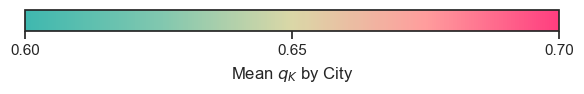

In [7]:
##### Visualisation: Custom gradient colormap for Fig 2a


# Recreate the custom gradient colormap
# Sample colors from the colormap
colors = [cmap(i) for i in np.linspace(0, 1, 5)]

# Create custom colormap from these colors
n_bins = 256
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', colors, N=n_bins)

# Create figure with colorbar
fig, ax = plt.subplots(figsize=(6, 1.1))

# Create a normalization based on the qK range
norm = Normalize(vmin=0.6, vmax=0.7)

# Create colorbar
cb = ColorbarBase(ax, cmap=custom_cmap, norm=norm, orientation='horizontal')
cb.set_label('Mean $q_K$ by City', fontsize=12)
cb.set_ticks([0.6, 0.65, 0.7])

plt.tight_layout()
# plt.savefig('figures/qk-cmap.svg')
plt.show()

## Fig 2b. Comparison with the null model

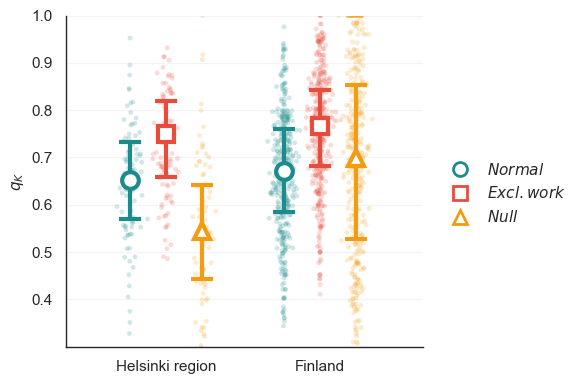

In [8]:
# Filter grids with more than 5 users to minimise noise
grid_filtered = qk_grid[qk_grid['n_users'] > 5]

# Define city groups
helsinki_region = ['Helsinki', 'Espoo', 'Kauniainen', 'Vantaa']
helsinki = grid_filtered[grid_filtered['city'].isin(helsinki_region)]
other_cities = grid_filtered[~grid_filtered['city'].isin(helsinki_region)]

# Prepare data for plotting
groups = [helsinki, other_cities]
group_names = ['Helsinki region', 'Finland']

# Metrics
metric_names = ['$Normal$', '$Excl. work$', '$Null$']
metric_cols  = ['mean_qk', 'mean_qk_nw', 'mean_qk_null']

metric_colors = ['#1B8B8B', '#E74C3C', '#F39C12']
metric_markers = ['o', 's', '^']

group_gap = 0.35
metric_step = 0.28

fig, ax = plt.subplots(figsize=(6, 4))

# Collect data for scatter plot
scatter_points = []

# Violin plot data
# violin_data = []
# violin_positions = []
# violin_colors = []

x_position = 0
x_labels = []
x_label_positions = []

np.random.seed(42)  # For reproducibility

from scipy.stats import gaussian_kde

for group_idx, (data_group, group_name) in enumerate(zip(groups, group_names)):
    group_start = x_position

    for metric_idx, (metric_col, metric_name, marker, color) in enumerate(
        zip(metric_cols, metric_names, metric_markers, metric_colors)
    ):
        data = data_group[metric_col].dropna()

        if len(data) > 0:
            # Sample 10% of the data for scatter plot
            sample_size = max(1, int(len(data) * 0.2))
            sampled_indices = np.random.choice(len(data), size=sample_size, replace=False)
            sampled_data = data.iloc[sampled_indices].values
            
            # Calculate density-based jitter width
            # Estimate KDE at each sampled point
            try:
                kde = gaussian_kde(data.values)
                densities = kde(sampled_data)
                # Normalize densities to create jitter width (higher density = wider spread)
                density_normalized = densities / densities.max()
                max_jitter = 0.05  # Maximum jitter width
                jitter_widths = density_normalized * max_jitter
            except:
                # Fallback if KDE fails
                jitter_widths = np.full(sample_size, 0.02)
            
            # Create jitter positions with density-aware spreading
            jitter_x = np.array([np.random.normal(x_position, jw) for jw in jitter_widths])
            
            # Store scatter data
            scatter_points.append({
                'x': jitter_x,
                'y': sampled_data,
                'color': color,
                'alpha': 0.2
            })
            
            # # Add violin plot data
            # p10_val = data.quantile(0.10)
            # p90_val = data.quantile(0.90)
            # data_filtered = data[(data >= p10_val) & (data <= p90_val)]
            # violin_data.append(data_filtered.values)
            # violin_positions.append(x_position)
            # violin_colors.append(color)
            
            med = data.median()
            p10_val = data.quantile(0.10)
            q1_val = data.quantile(0.25)
            q3_val = data.quantile(0.75)
            p90_val = data.quantile(0.90)

            ax.errorbar(
                x_position, med,
                yerr=[[med - q1_val], [q3_val - med]],
                fmt=marker, linestyle='none',
                markersize=12, color=color,
                markerfacecolor='white',
                markeredgecolor=color,
                markeredgewidth=3,
                capsize=8, capthick=2, elinewidth=3, alpha=1, zorder=3
            )

            # ax.errorbar(
            #    x_position, med, 
            #    yerr=[[med - p10_val], [p90_val - med]],
            #    color=color,
            #    capsize=4, capthick=1, elinewidth=1.5, alpha=1, zorder=2
            # )

        x_position += metric_step

    x_label_positions.append(group_start + (metric_step * (len(metric_cols)-1)) / 2)
    x_labels.append(group_name)
    x_position += group_gap

# Plot scatter/jitter points (with lower z-order to appear behind errorbars)
for scatter in scatter_points:
    ax.scatter(scatter['x'], scatter['y'], color=scatter['color'], 
              alpha=scatter['alpha'], s=12, zorder=1, edgecolors='none')

# Legends
from matplotlib.lines import Line2D

metric_legend = [
    Line2D([0], [0], marker=m, linestyle='none',
           markerfacecolor='white', markeredgecolor=c, markeredgewidth=2,
           color=c, markersize=10, label=lab)
    for m, c, lab in zip(metric_markers, metric_colors, metric_names)
]

ax.legend(handles=metric_legend, loc='upper left', bbox_to_anchor=(1.02, 0.6),
        #   title='Metrics', 
          framealpha=0)

ax.set_ylim(0.3, 1)
ax.set_ylabel('$q_K$', fontsize=11)
ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels(['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
ax.grid(axis='y', alpha=0.2)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(x_label_positions)
ax.set_xticklabels(x_labels)
ax.margins(x=0.2)

plt.tight_layout()

# plt.subplots_adjust(right=0.75)
# plt.savefig('figures/qk-null-1.svg')
plt.show()


## Fig 2c-d. POI diversity and income segregation between the three scenarios

The below codes provide codes to reproduce the data aggregation procedures from the K-visitation data in the three scenarios to obtain the grid-level metrics used in Fig 2c-d. 

The calls to the functions are commented out.

In [9]:
def _filter_k_places_for_operation(df, operation):
    """
    Filter K-places by the requested operation.
    operation options:
        - 'k_freq_only': k_freq == 1 & k_dist != 1
        - 'k_dist_only': k_dist == 1 & k_freq != 1
        - 'both': k_freq == 1 & k_dist == 1
    """
    freq = df['k_freq'] if 'k_freq' in df.columns else pd.Series(0, index=df.index)
    dist = df['k_dist'] if 'k_dist' in df.columns else pd.Series(0, index=df.index)

    freq = freq.fillna(0)
    dist = dist.fillna(0)

    if operation == 'k_freq_only':
        mask = (freq == 1) & (dist != 1)
    elif operation == 'k_dist_only':
        mask = (dist == 1) & (freq != 1)
    elif operation == 'both':
        mask = (freq == 1) & (dist == 1)
    else:
        raise ValueError("operation must be one of: k_freq_only, k_dist_only, both")

    return df.loc[mask].copy()


def aggregate_diversity_and_segregation(df, operation='both'):
    """
    Aggregate POI diversity and visitation segregation by home grid for a K-place selection.

    Parameters
    ----------
    df : DataFrame
        Places dataframe with poi_div, visit_inc_seg/visit_inc_seg, k_freq, k_dist, and home_grd_id.
    operation : {'k_freq_only', 'k_dist_only', 'both'}
        Which K-place filter to apply before aggregation.

    Returns
    -------
    DataFrame with aggregated poi_div and segregation metrics per home_grd_id.
    """
    if 'poi_div' not in df.columns:
        raise KeyError("Expected column 'poi_div' in dataframe.")

    seg_col = 'visit_inc_seg' if 'visit_inc_seg' in df.columns else 'visit_inc_seg'
    if seg_col not in df.columns:
        raise KeyError("Expected segregation column 'visit_inc_seg' or 'visit_inc_seg'.")

    filtered = _filter_k_places_for_operation(df, operation)
    if filtered.empty:
        return pd.DataFrame(columns=[
            'home_grd_id', 'operation', 'n_users', 'n_places',
            'poi_div_mean', 'poi_div_median', 'poi_div_std',
            'visit_inc_seg_mean', 'visit_inc_seg_median', 'visit_inc_seg_std'
        ])
    

    agg = filtered.groupby('home_grd_id').agg(
        poi_div_mean=('poi_div', 'mean'),
        poi_div_median=('poi_div', 'median'),
        poi_div_p10=('poi_div', lambda x: x.quantile(0.10)),
        poi_div_p25=('poi_div', lambda x: x.quantile(0.25)),
        poi_div_p75=('poi_div', lambda x: x.quantile(0.75)),
        poi_div_p90=('poi_div', lambda x: x.quantile(0.90)),
        visit_inc_seg_mean=(seg_col, 'mean'),
        visit_inc_seg_median=(seg_col, 'median'),
        visit_inc_seg_p10=(seg_col, lambda x: x.quantile(0.10)),
        visit_inc_seg_p25=(seg_col, lambda x: x.quantile(0.25)),
        visit_inc_seg_p75=(seg_col, lambda x: x.quantile(0.75)),
        visit_inc_seg_p90=(seg_col, lambda x: x.quantile(0.90)),
        n_places=('user_id', 'size'),
        n_users=('user_id', 'nunique')
    ).reset_index()

    agg.insert(1, 'operation', operation)
    cols = ['home_grd_id', 'operation', 'n_users', 'n_places',
            'poi_div_mean', 'poi_div_median', 'poi_div_p10', 'poi_div_p25', 'poi_div_p75','poi_div_p90',
            'visit_inc_seg_mean', 'visit_inc_seg_median', 'visit_inc_seg_p10','visit_inc_seg_p25','visit_inc_seg_p75','visit_inc_seg_p90'
            ]
    return agg[cols]


def calculate_all_poi_diversity_and_segregation(places_k, places_k_nw, places_k_null):
    """
    Calculate poi_div and visit income segregation for each K-place scheme and operation.

    Returns
    -------
    dict: {dataset_name: {operation: DataFrame, 'combined': DataFrame}}
    """
    datasets = {
        'places_k': places_k,
        'places_k_nw': places_k_nw,
        'places_k_null': places_k_null
    }
    operations = ['k_freq_only', 'k_dist_only', 'both']

    results = {}
    for dataset_name, dataset in datasets.items():
        results[dataset_name] = {}
        combined = []

        for op in operations:
            agg_df = aggregate_diversity_and_segregation(dataset, operation=op)
            results[dataset_name][op] = agg_df
            if not agg_df.empty:
                combined.append(agg_df)

            n_users = int(agg_df['n_users'].sum()) if not agg_df.empty else 0
            n_places = int(agg_df['n_places'].sum()) if not agg_df.empty else 0
            print(f"{dataset_name} - {op}: {len(agg_df)} grids, {n_users} users, {n_places} places")

        results[dataset_name]['combined'] = pd.concat(combined, ignore_index=True) if combined else pd.DataFrame()

    return results

In [10]:
# # Aggregate poi_div and isit_inc_seg for each scenario and dataset
# poi_div_seg_results = calculate_all_poi_diversity_and_segregation(
#     places_k, places_k_nw, places_k_null
# )


# # Extract k_freq_only and k_dist_only aggregates per dataset
# plot_frames = []
# plot_datasets = ['places_k', 'places_k_nw', 'places_k_null']

# for dataset in plot_datasets:
#     dataset_results = poi_div_seg_results.get(dataset, {})
#     freq_df = dataset_results.get('k_freq_only', pd.DataFrame())
#     dist_df = dataset_results.get('k_dist_only', pd.DataFrame())

#     if freq_df.empty or dist_df.empty:
#         print(f"{dataset}: missing k_freq_only or k_dist_only data; skipping.")
#         continue

#     merged = freq_df[['home_grd_id', 'poi_div_mean', 'visit_inc_seg_mean']].merge(
#         dist_df[['home_grd_id', 'poi_div_mean', 'visit_inc_seg_mean']],
#         on='home_grd_id',
#         suffixes=('_k_freq', '_k_dist')
#     )

#     merged['div_diff'] = merged['poi_div_mean_k_freq'] - merged['poi_div_mean_k_dist']
#     merged['seg_diff'] = merged['visit_inc_seg_mean_k_freq'] - merged['visit_inc_seg_mean_k_dist']
#     merged['dataset'] = dataset
#     plot_frames.append(merged)

# poi_seg_plot_df = pd.concat(plot_frames, ignore_index=True) if plot_frames else pd.DataFrame()

In [11]:
poi_seg_plot_df = pd.read_csv(data_dir / 'poi_seg_diff.csv')

Text(0.5, 0, '$\\Delta{POI.Div.} (K_{freq} - K_{dist})$')

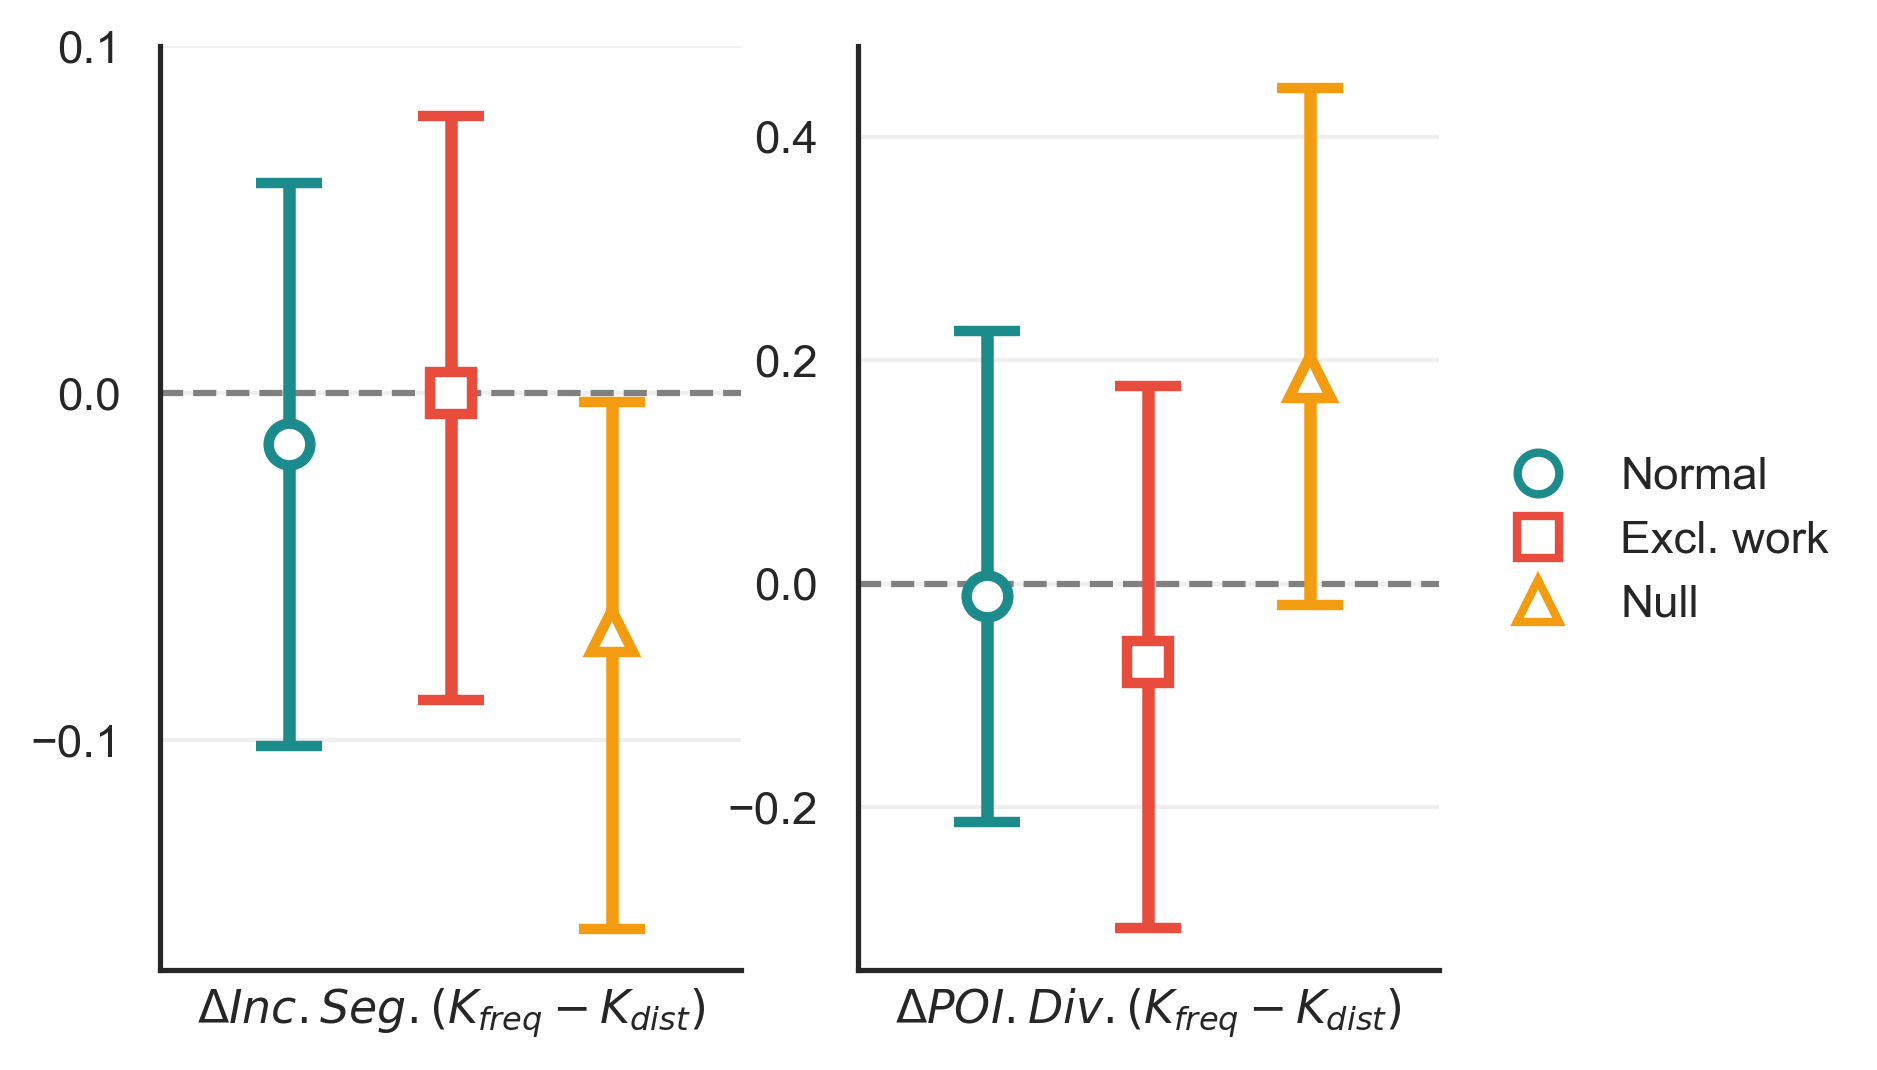

In [12]:
# Single group (all grids)
poi_seg_plot_df['group'] = 'All grids'
groups = ['places_k', 'places_k_nw', 'places_k_null']

metric_info = [
    ('places_k', 'Normal', '#1B8B8B', 'o'),
    ('places_k_nw', 'Excl. work', '#E74C3C', 's'),
    ('places_k_null', 'Null', '#F39C12', '^'),
]

group_gap = 0.05
metric_step = 0.28

fig, axes = plt.subplots(1, 2, figsize=(5.5, 4), sharey=False, dpi=300)

for ax, (metric_col, title) in zip(axes, [('seg_diff', 'Segregation difference'), ('div_diff', 'POI diversity difference')]):
    x_position = 0
    x_labels = []
    x_label_positions = []

    for group_name in groups:
        group_start = x_position
        group_data = poi_seg_plot_df[poi_seg_plot_df['dataset'] == group_name]

        for dataset, label, color, marker in metric_info:
            data = group_data.loc[group_data['dataset'] == dataset, metric_col].dropna()

            if len(data) > 0:
                med = data.median()
                q1_val = data.quantile(0.25)
                q3_val = data.quantile(0.75)

                ax.errorbar(
                    x_position, med,
                    yerr=[[med - q1_val], [q3_val - med]],
                    fmt=marker, linestyle='none',
                    markersize=10, color=color,
                    markerfacecolor='white',
                    markeredgecolor=color,
                    markeredgewidth=2.5,
                    capsize=8, capthick=2, elinewidth=3, alpha=1, zorder=3
                )

            x_position += metric_step

        x_label_positions.append(group_start + (metric_step * (len(metric_info) - 1)) / 2)
        x_labels.append(group_name)
        x_position += group_gap

    if ax is axes[1]:
        from matplotlib.lines import Line2D
        metric_legend = [
            Line2D([0], [0], marker=m, linestyle='none',
                   markerfacecolor='white', markeredgecolor=c, markeredgewidth=2,
                   color=c, markersize=10, label=lab)
            for _, lab, c, m in metric_info
        ]
        ax.legend(handles=metric_legend, loc='upper left', bbox_to_anchor=(1.02, 0.6),
                  framealpha=0)

    ax.axhline(0, color='grey', linestyle='--', linewidth=1.5)

    ax.grid(axis='y', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(' ')
    ax.margins(x=0.4)

axes[0].set_yticks([-0.1, 0, 0.1])
axes[1].set_yticks([-0.2, 0, 0.2, 0.4])
axes[0].set_xlabel(r'$\Delta{Inc. Seg.} (K_{freq} - K_{dist})$', fontsize=11)
axes[1].set_xlabel(r'$\Delta{POI.Div.} (K_{freq} - K_{dist})$', fontsize=11)

## Fig 3. Spatial distribution of $q_K$ in the four major urban regions in Finland

In [13]:
# Load grid shapefile for mapping
grid_df = gpd.read_parquet(data_dir / 'grid_finland.geoparquet')

# Merge qk data with grid geometries
grid_qk_plot = grid_df.merge(
    qk_grid,
    on='grd_id',
    how='left',
)

Plotting Helsinki Region...


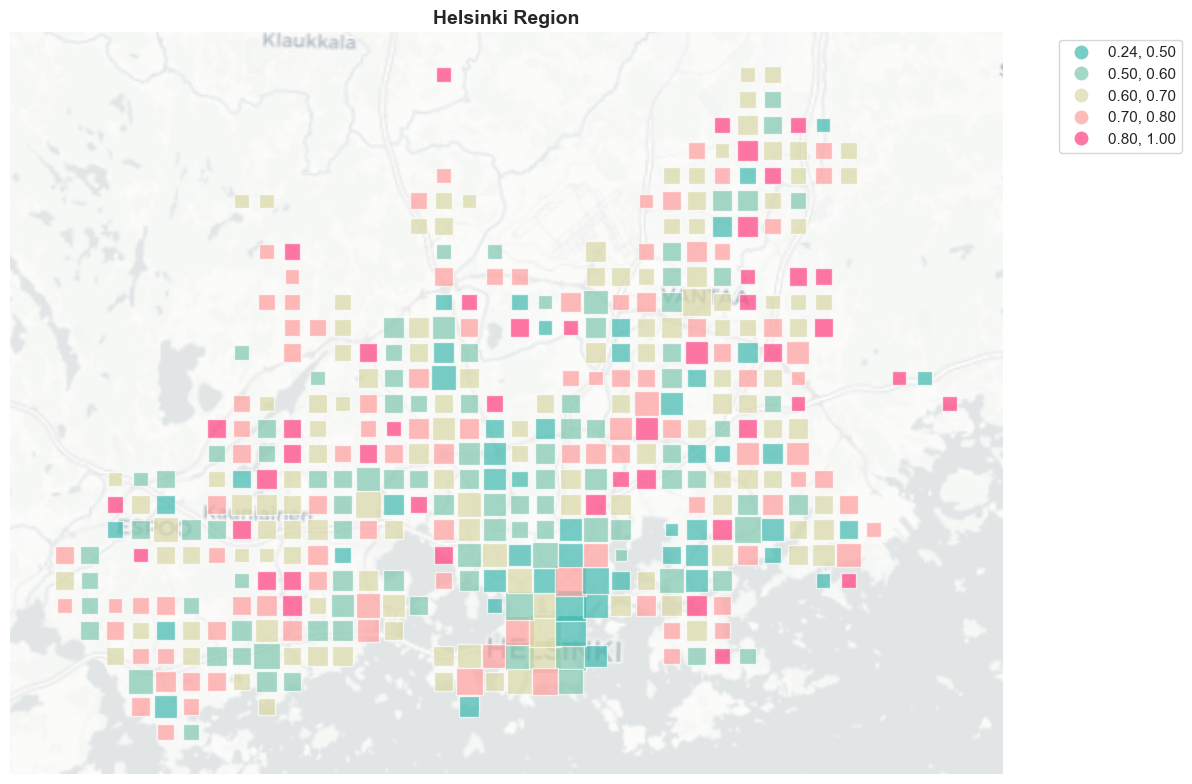

Plotting Tampere Region...


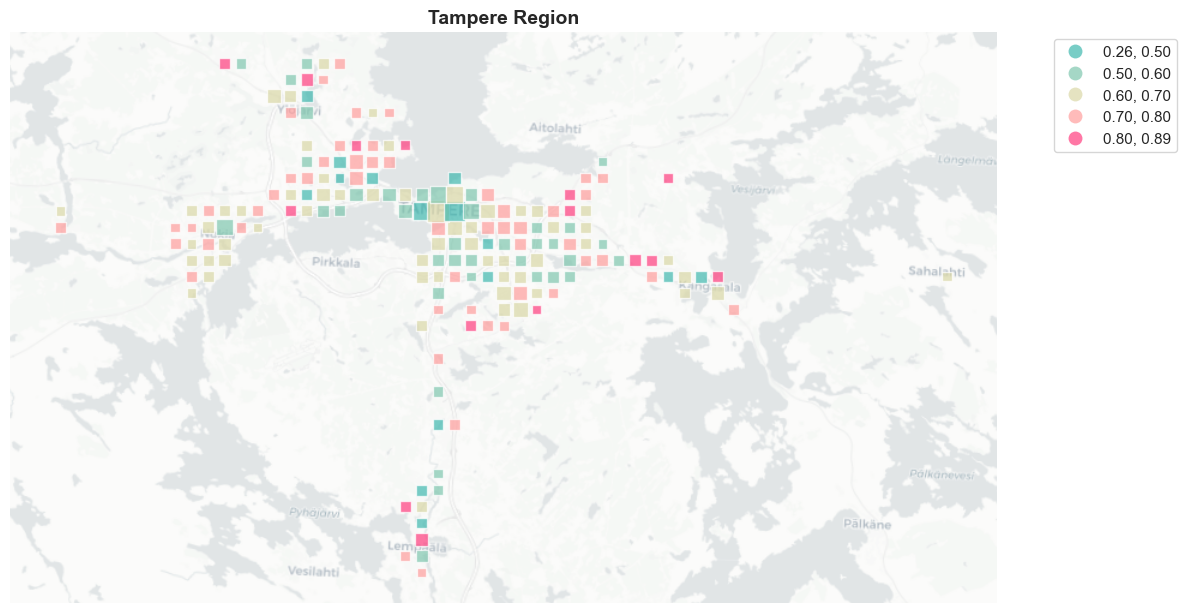

Plotting Turku Region...


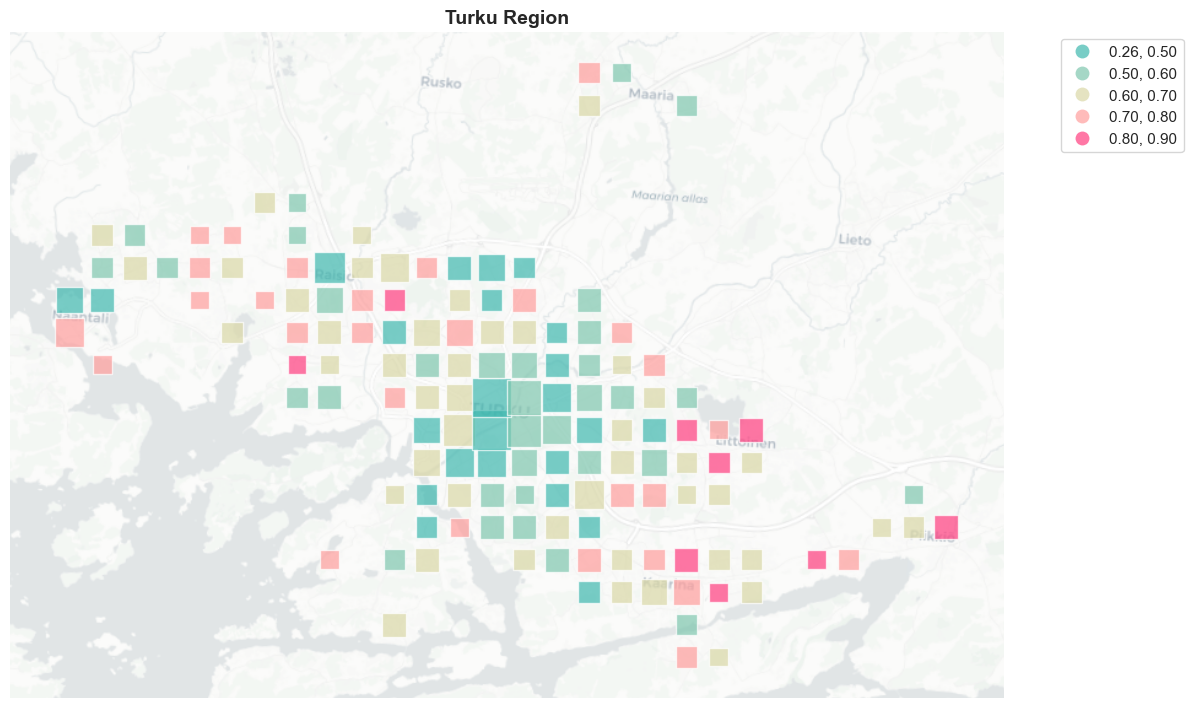

Plotting Oulu Region...


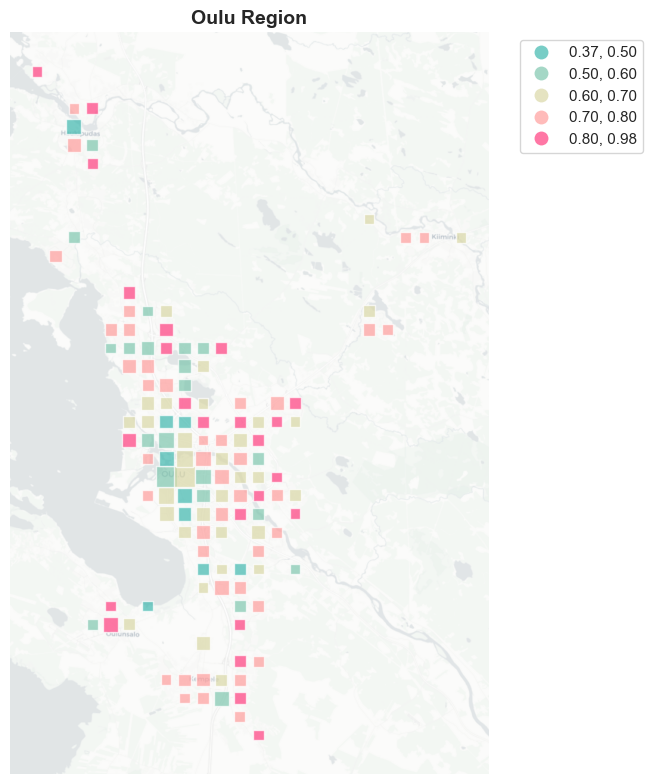

In [14]:
# Functions for Processing and Plotting
def prepare_scaled_geometries(gdf, min_size=0.5, max_size=1.3):
    """
    Scale geometries based on POI density bins (log transformed).
    Returns a new GeoDataFrame with scaled geometries.
    """
    # Create a copy and ensure index is reset for positional alignment
    gdf_scaled = gdf.copy().reset_index(drop=True)
    
    # Bin-based resizing method parameters
    values = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    
    # Calculate log POI
    poi_sum_log = np.log1p(gdf_scaled['log_poi'].fillna(0))

    # Assign each observation to a bin
    bin_indices = np.digitize(poi_sum_log, values, right=True)
    bin_indices = np.clip(bin_indices, 0, len(values) - 1)

    # Create uniform size factors for each bin
    n_bins = len(values)
    if n_bins > 1:
        bin_size_factors = np.linspace(min_size, max_size, n_bins)
    else:
        bin_size_factors = np.array([1.0])

    # Assign size factors
    size_factors = bin_size_factors[bin_indices]

    # Apply scaling to geometries using list comprehension (faster than iterating rows)
    from shapely.affinity import scale
    
    new_geoms = []
    for geom, factor in zip(gdf_scaled['geometry'], size_factors):
        if geom is not None:
             new_geoms.append(scale(geom, xfact=factor, yfact=factor, origin='centroid'))
        else:
             new_geoms.append(None)
             
    gdf_scaled['geometry'] = new_geoms
    return gdf_scaled

def plot_qk_for_region(gdf, cities, title=None, ax=None):
    """
    Plot qK distribution for a given list of cities on a specific axes.
    """
    # Filter data for the requested cities
    plot_data = gdf[gdf['city'].isin(cities)]
    
    if plot_data.empty:
        print(f"Note: No data found for cities: {cities}")
        return

    # Setup plot if ax not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Visual parameters
    cmap = load_cmap('miami2')
    cut = [0.5, 0.6, 0.7, 0.8]

    # Plot the scaled grids
    plot_data.plot(
        column='mean_qk',
        cmap=cmap,
        scheme='user_defined',
        classification_kwds={'bins': cut},
        k=5,
        alpha=0.7,
        legend=True,
        ax=ax,
        linewidth=1,
        edgecolor='white',
        legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'},
        zorder=5
    )

    # Add basemap
    ctx.add_basemap(
        ax,
        crs=gdf.crs.to_string(),
        source=ctx.providers.CartoDB.Positron,
        alpha=0.7,
        attribution=False
    )

    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')
    
    ax.axis('off')


# --- Main Execution ---

grid_qk_plot = grid_df.merge(
    qk_grid,
    on='grd_id',
    how='left',
)

# print("Scaling geometries based on POI density...")
grid_qk_plot_scaled = prepare_scaled_geometries(grid_qk_plot)

# Define regions to plot
regions = {
    'Helsinki Region': ['Helsinki', 'Espoo', 'Vantaa', 'Kauniainen'],
    'Tampere Region': ['Tampere', 'Lempäälä', 'Kangasala', 'Ylöjärvi', 'Nokia'],
    'Turku Region': ['Turku', 'Raisio', 'Naantali', 'Kaarina'],
    'Oulu Region': ['Oulu', 'Kempele', 'Li']
}

# Iterate and Plot each region
for region_name, city_list in regions.items():
    print(f"Plotting {region_name}...")
    fig, ax = plt.subplots(figsize=(12, 8))
    
    plot_qk_for_region(grid_qk_plot_scaled, city_list, title=region_name, ax=ax)
    
    plt.tight_layout()
    plt.show()